In [1]:
import csv
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import functools
from tqdm import tqdm_notebook as tqdm

/home/mattmann/install/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mattmann/install/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mattmann/install/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mattmann/install/python37/lib/python3.7/site-pack

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.enable_eager_execution(config=config)

In [3]:
def read(filename, date_idx, date_parse, year=None, bucket=7):
    days_in_year = 365
    
    freq = {}
    if year != None:
         for period in range(0, int(days_in_year / bucket)):
            freq[period] = 0
        
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)
        for row in csvreader:
            if row[date_idx] == '':
                continue
            
            t = time.strptime(row[date_idx], date_parse)
            if year == None:
                if not t.tm_year in freq:
                    freq[t.tm_year] = {}
                    for period in range(0, int(days_in_year / bucket)):
                        freq[t.tm_year][period] = 0
                
                if t.tm_yday < (days_in_year - 1):
                    freq[t.tm_year][int(t.tm_yday / bucket)] += 1
                    
            else:
                if t.tm_year == year and t.tm_yday < (days_in_year-1):
                    freq[int(t.tm_yday / bucket)] += 1
    
    return freq


In [4]:
def split_dataset(x_dataset, y_dataset, ratio):
    arr = np.arange(x_dataset.size)
    np.random.shuffle(arr)
    num_train = int(ratio * x_dataset.size)
    x_train = x_dataset[arr[0:num_train]]
    x_test = x_dataset[arr[num_train:x_dataset.size]]
    y_train = y_dataset[arr[0:num_train]]
    y_test = y_dataset[arr[num_train:x_dataset.size]]
    return x_train, x_test, y_train, y_test

# Read the 311 data 
Take in the 311 data. I couldn't find the LA 311 data from the book, I used the [NYC 311 data](https://data.cityofnewyork.us/Social-Services/311-csv/i4zx-95p9). The format was basically the same except the times included hours, minutes, and seconds.  One odd thing about it though - it looks like only a partial set of calls from the summer of 2014, so because of that, the data is super weird and looks more like a bell curve. That's fine, if you Google around, you'll see that the model that looks most like a bell curve is a [1 dimensional Gaussian function](https://stackoverflow.com/questions/14873203/plotting-of-1-dimensional-gaussian-distribution-function). I found Python code online that shows this. So, let's try and learn a model for it. Here's another [link](https://github.com/aakhundov/tf-example-models) to read more about Python, Gaussian and Tensorflow.

In [5]:
freq = read('../../data/311.csv', 1, '%m/%d/%Y %H:%M:%S %p', 2014)

In [6]:
freq

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 10889,
 22: 40240,
 23: 42125,
 24: 42673,
 25: 41721,
 26: 38446,
 27: 41915,
 28: 41008,
 29: 39011,
 30: 36069,
 31: 38821,
 32: 37050,
 33: 36967,
 34: 26834,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0}

Num samples 52


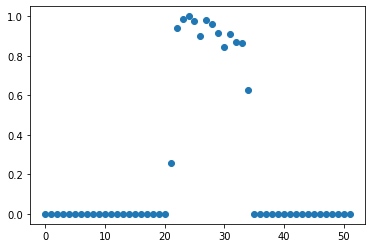

In [9]:
X_train = np.asarray(list(freq.keys()))
Y_train = np.asarray(list(freq.values()))
print("Num samples", str(len(X_train)))
maxY = np.max(Y_train)
nY_train = Y_train / np.max(Y_train)

plt.scatter(X_train, nY_train)
plt.show()

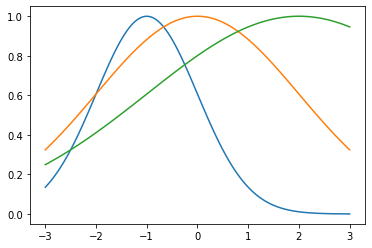

In [10]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
x_values = np.linspace(-3, 3, 120)
for mu, sig in [(-1, 1), (0, 2), (2, 3)]:
    plt.plot(x_values, gaussian(x_values, mu, sig))

plt.show()

In [262]:
learning_rate = 1.5
training_epochs = 5000
momentum=0.979

In [263]:
X = tf.constant(X_train, dtype=tf.float32)
Y = tf.constant(nY_train, dtype=tf.float32)
mu = tf.Variable(1., name="mu")
sig = tf.Variable(1., name="sig")

In [264]:
model = lambda _X, _sig, _mu: tf.exp(tf.div(tf.negative(tf.pow(tf.subtract(tf.cast(_X,tf.float32), _mu), 2.)), tf.multiply(2., tf.pow(_sig, 2.))))
y_model = lambda: model(X, mu, sig)
cost = lambda: tf.square(Y - y_model())

In [265]:
train_op = tf.keras.optimizers.SGD(learning_rate, momentum=momentum)

In [266]:
for epoch in tqdm(range(training_epochs)):
    train_op.minimize(cost, mu, sig)

mu_val = mu.value()
sig_val = sig.value()

/home/mattmann/install/python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [267]:
print(mu_val.numpy())
print(sig_val.numpy())

19.272867
1.0


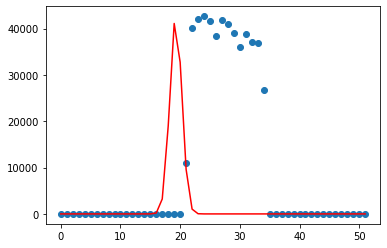

Prediction of week 35 5.1545538e-37
Actual week 35 36967


In [268]:
plt.scatter(X_train, Y_train)
trY2 = maxY * (np.exp(-np.power(X_train - mu_val, 2.) / (2 * np.power(sig_val, 2.))))
plt.plot(X_train, trY2, 'r')
plt.show()
print("Prediction of week 35", trY2[33])
print("Actual week 35", Y_train[33])

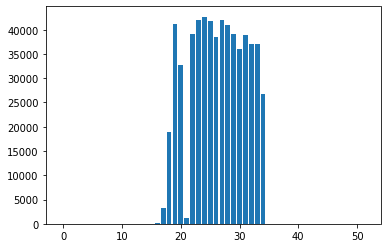

Average Error 7823.147135779301
Accuracy 0.816672201725229


In [269]:
# plot the error
error = np.power(np.power(trY2 - Y_train, 2), 0.5)
plt.bar(X_train, error)
plt.show()

# compute the overall average error
avg_error = functools.reduce(lambda a,b: a+b, (trY2-Y_train))
avg_error = np.abs(avg_error) / len(X_train)
print("Average Error", avg_error)
acc = 1. - (avg_error / maxY)
print("Accuracy", acc)

# Use Regularization
We'll use regularlization and .7 / .3 train/test split to see if it helps. I'm omitting this portion from the notebook. The short answer is that I tried it, and basically it did what regularliation is supposed to do. It penalized higher values for the weights, in this case, mu and dig, and in doing so, didn't allow it to explore the way it needed to. It made the model learn a function based on the training data where it was missing data early on, and b/c of that, it thought the bell curve started there. Instead, I'll take the train/test split idea and use that to run the same model annd then evaluate it on the unseen data for test.

Some cool links to read about regularization:

  1. [Regularization using Tensorflow](http://www.godeep.ml/regularization-using-tensorflow/)
  2. [The Art of Regularization](https://greydanus.github.io/2016/09/05/regularization/)
  3. [Stochastic versus Mini-batch learning](https://medium.com/coinmonks/stochastic-vs-mini-batch-training-in-machine-learning-using-tensorflow-and-python-7f9709143ee2)

# Train/Test Split results
Here's the short answer on the results from train/test split. I tried a 0.7 train test split. Interestingly enough, with the same learning rate (1.5), the model learned very small values of sig and mu, and never could break out of learning a similar result from regularization. That is, that there was an early peak, and to try and model that. It seems without the full continuous data from each week, the Gaussian model can't figure out where the peak begins, ends, and its width. So, the best answer with the highest accuracy is the Gaussian fit done initially on all the data.